In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report

In [69]:
""" 
This function prints out a confusion matrix specifically for this task. The labels are defined inside the function for that reason.
It will print the confusion matrix values as percentages by default and raw counts if the data is specified otherwise.
"""
def print_ConfusionMatrix(cm:confusion_matrix, title:str, normalized:bool):
    labels = ["Looking for job", "Not looking for job"]

    plt.figure(figsize=(6, 5))
    if(normalized == True):
        fmt = ".2%"
    else:
        fmt = "d"
    sns.heatmap(cm, annot=True, fmt = fmt, cmap='coolwarm',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [70]:
train_data = pd.read_csv("aug_train.csv", delimiter = ",")
test_data = pd.read_csv("aug_test.csv", delimiter = ",")

In [71]:
test_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


We plan to create a classification model that can  accurately predict if people are looking for a job change or not. The predictors we plan to look at are: company type, company size, training hours, last new job, education level, experience, and relevant experience.

Important things to note: 
There are quite a lot of missing values: 32% of the company type responses are missing values, which could be for a variety of reasons, maybe some people do not know the type of company they work for, have NDA's. That's a good chunck of the data to just ignore, so we plan to keep track of them using: dummy_na is 'True' for get dummies

29% missing values for company size, 2% missing values for last new job, <1% for experience, and 2% for education level.

First, we will be visualizing the data of our chosen predictors before splitting the data.

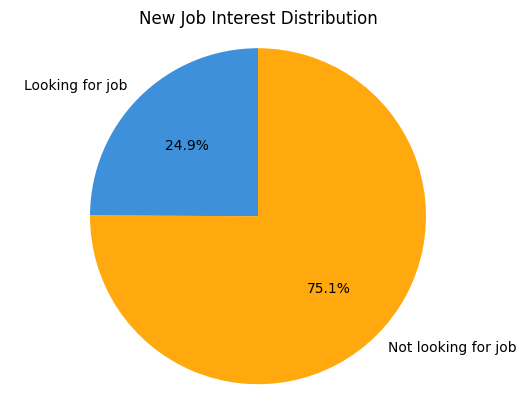

<Figure size 1920x1440 with 0 Axes>

In [72]:
#Define style to use for visualizations
plt.style.use("petroff10")

#Pie chart to understand the distribution of people looking for a job (where target = 1), and people that will be staying (where target = 0)
labels = ["Looking for job", "Not looking for job"]
Job_Change = train_data["target"].sum()
No_Job_Change = (train_data["target"] == False).sum()
counts = [Job_Change, No_Job_Change]

plt.pie(counts, labels=labels, autopct='%.1f%%', startangle=90)
plt.title("New Job Interest Distribution")
plt.axis('equal')  # Equal aspect ratio makes the pie circular
plt.figure(dpi = 300)
plt.show()

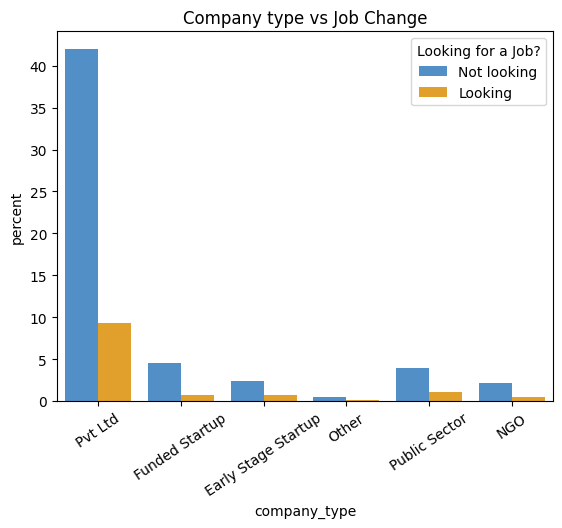

<Figure size 1920x1440 with 0 Axes>

In [73]:
#Plotting the predictor (company type to our target)
sns.countplot(x='company_type', hue='target', stat= "percent" ,data=train_data)
plt.title("Company type vs Job Change")
plt.legend(title = "Looking for a Job?", labels = ["Not looking","Looking"] )
plt.xticks(rotation=34)
plt.figure(dpi = 300)
plt.show()

One thing we do notice is that the higher the percentage of people, from a particular group willing to stay, the higher the people looking for a job change within that same group which makes sense in hindsight. In this case, the people workng in the private limited company, Pvt Ltd, are more willing to stay with the company after training, but they also have the higher percentage, when comparing amongst others, of people looking to branch out. The other company types have a smaller population, so their contributions are understandably lower.

<Figure size 1920x1440 with 0 Axes>

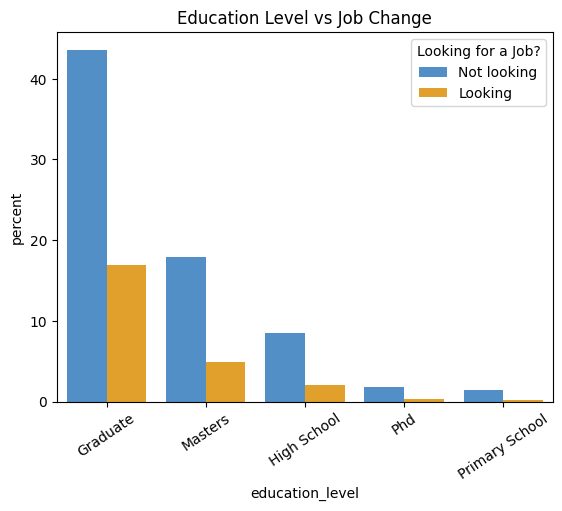

<Figure size 1920x1440 with 0 Axes>

In [74]:
#Plotting the predictor (education level to our target)
sns.countplot(x='education_level', hue='target', stat="percent", data=train_data)
plt.title("Education Level vs Job Change")
plt.legend(title = "Looking for a Job?", labels = ["Not looking","Looking"] )
plt.xticks(rotation=34)
plt.figure(dpi = 300)

Similarly, when looking at results from their education level, graduates make up more of the population in this case and as a result, have a higher percentage of people both willing to stay and willing to leave, compared to the other levels like masters and Phd students. It was not specified what exactly graduates mean as they have both masters and Phd students as differnt options in this category, but we assume that 'graduates' refer to people that have completed their undergraduate degree.

Text(0.5, 1.0, 'Training hours vs Job Change')

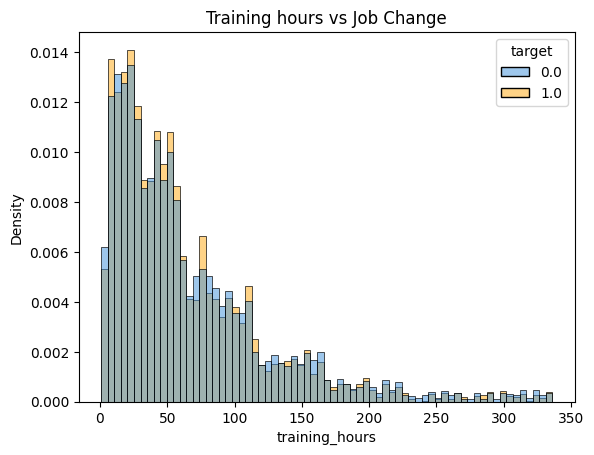

In [93]:
#Plotting the predictor (training hours to our target)
sns.histplot(data=train_data, x='training_hours', hue='target', stat='density', common_norm=False)
plt.title("Training hours vs Job Change")

Training hours are numerical value, so we chose to visualize them using historgramsa density plot. Training hours refer to how long the participants have spent training with the company. There seems to be a lot of overlap between the poeple who choose to stay and the people that choose to leave the company in search of a new job. Additionally, the data is skewed where more people have less than 100 hours in training.

<Figure size 1920x1440 with 0 Axes>

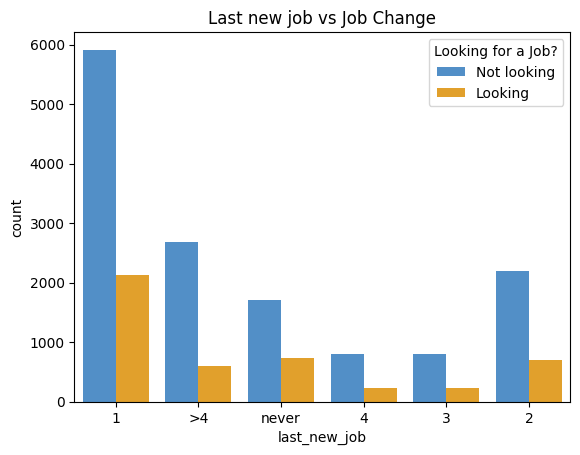

<Figure size 1920x1440 with 0 Axes>

In [76]:
#Plotting the predictor (last new job to our target)
sns.countplot(x='last_new_job', hue='target', data=train_data)
plt.legend(title = "Looking for a Job?", labels = ["Not looking","Looking"] )
plt.title("Last new job vs Job Change")
plt.xticks(rotation=0)
plt.figure(dpi = 300)

The variable 'last new job' works similarly to the predictor company type, because the more the population within a particularly category, the higher the percentage of people both looking to stay and leave.

<Figure size 1920x1440 with 0 Axes>

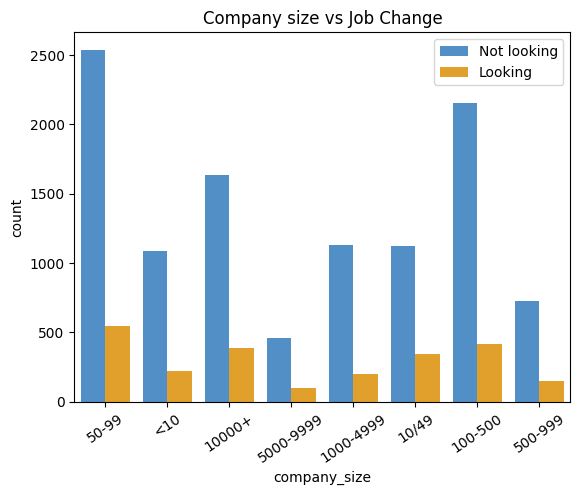

<Figure size 1920x1440 with 0 Axes>

In [77]:
#Plotting the predictor (company size to our target)
sns.countplot(x='company_size', hue='target', data=train_data)
plt.title("Company size vs Job Change")
plt.legend(labels = ["Not looking","Looking"] )
plt.xticks(rotation=34)
plt.figure(dpi = 300)

The variable company size works similarly to the predictor company type, because the more the population within a particularly category, the higher the percentage of people both looking to stay and leave.

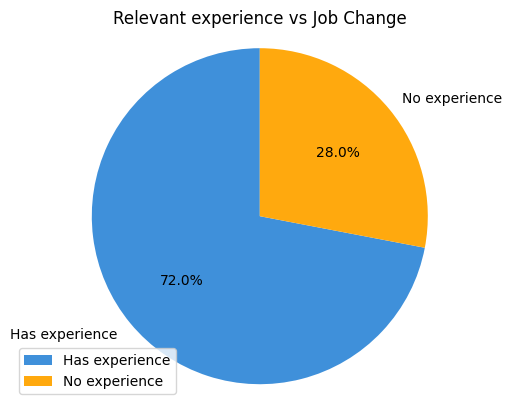

<Figure size 1920x1440 with 0 Axes>

In [78]:
#Plotting the preidctor (relevant experience to target)
labels = ["Has experience", "No experience"]
dummies_rel_exp = pd.get_dummies(train_data["relevent_experience"])
rel_exp = dummies_rel_exp["Has relevent experience"].sum()
no_rel_exp = dummies_rel_exp["No relevent experience"].sum()
counts = [rel_exp, no_rel_exp]

plt.pie(counts, labels=labels, autopct='%.1f%%', startangle=90)
plt.title("Relevant experience vs Job Change")
plt.legend(labels = ["Has experience", "No experience"])
plt.axis('equal')
plt.figure(dpi = 300)
plt.show()

This pie chart shows the distribution of applicants/people that have relevant experience compared to the people that do not have relevant experience. It was not specified, but we assumed relevant experience to refer to people with direct experience in the field of data science prior to being involved in this program

<Figure size 1920x1440 with 0 Axes>

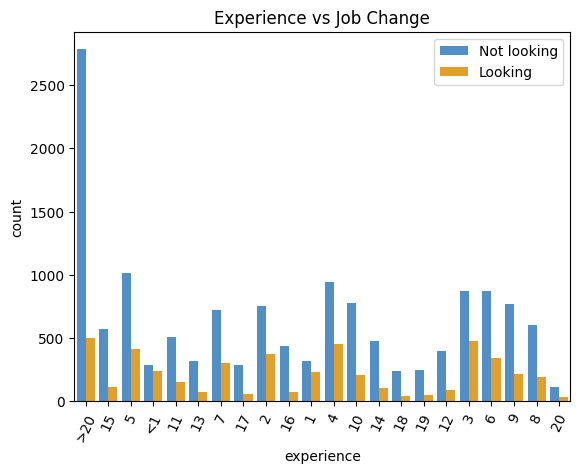

<Figure size 1920x1440 with 0 Axes>

In [79]:
#Plotting the predictor (experience to target)
sns.countplot(x='experience', hue='target', data=train_data)
plt.title("Experience vs Job Change")
plt.legend(labels = ["Not looking","Looking"] )
plt.xticks(rotation=65)
plt.figure(dpi = 300)

We notice a similar trend, the more the population of people in a category, the higher the percentage of people willing to stay and willing to leave. Additionally, it was not really clear the distinction between the variables 'relevant experience' and 'experience', but 'experience' refers to the total experience of a candidate in years, which we assumed to be total experience they have in their present field. We assumed this because there were instances where a candidate had 'no experience' in the 'relevant experience' category, but they had experience in the 'experience' variable.

In [80]:
#Converting categorical varaiables to dummy variables
train_dummies = pd.get_dummies(train_data, dummy_na= True)

labels = train_dummies["target"]
train_dummies.drop(["target","relevent_experience_nan","enrollee_id"], axis = 1,inplace = True)
x_train, x_test, y_train, y_test = train_test_split(train_dummies, labels, test_size = 0.2, random_state = 21)

In [81]:
train_dummies.head()

,city_development_index,training_hours,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_Public Sector,company_type_Pvt Ltd,company_type_nan,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,last_new_job_nan
0,0.920,36,False,False,False,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
1,0.776,47,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,0.624,83,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,0.789,52,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,0.767,8,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [128]:
#normalize training, validation, test data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [134]:
#Applying the random forest model to our training set
rf_model = RandomForestClassifier(bootstrap=True, class_weight="balanced", n_estimators=50,
                                  min_samples_split=15)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_train)

In [135]:
#Determining the accuracy of the model: How accurate is it in predicting the people that would leave?
hr_probs = rf_model.predict_proba(x_train)
hr_probs = hr_probs[:, 1]

threshold = 0.50
preds = (hr_probs >= threshold).astype(y_train.dtype)

hr_acc = np.mean(preds == y_train)
base_rate = np.mean(y_train)
rel_acc = np.abs((1 - base_rate) - hr_acc) * 100

print(f"Model Accuracy: {hr_acc:.5f}")
print(f"Model Relative Accuracy: {rel_acc:.2f}%")

Model Accuracy: 0.85867
Model Relative Accuracy: 10.81%


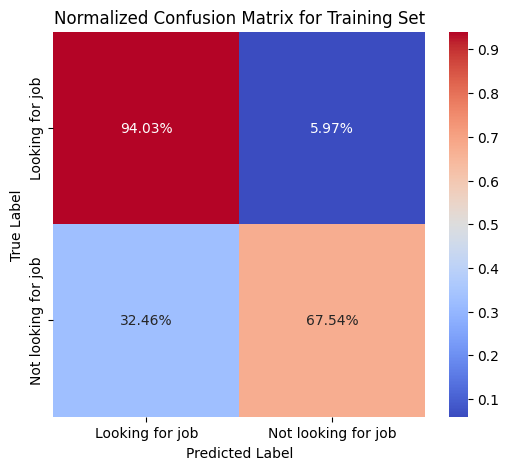

In [136]:
#Plotting the confusion matrix for the training data
train_results = (x_train.sum(axis=1) >= 6).astype(y_train.dtype)
train_cm = confusion_matrix(y_pred, y_train, normalize = "true")

print_ConfusionMatrix(train_cm, "Normalized Confusion Matrix for Training Set", normalized = True)

These results help us determine and understand the accuracy of our random forest model. The model has an accuracy of 0.85 indicating that it is doing a good job predicting the number of people that plan to leave the company for a new job after the training session is over. There could be a couple of reasons for this, but one of the major ones would be because of the breakdown of people planning to leave and stay after the training period. 

The number or people planning to leave the company is significantly lower than the number of people that plan to stay, with a percent of ~ 30%. Because the number of people planning to leave is very low, our model is guaranteed to do a good job predicting this percentage, but an anticipated problem would be on the false positives when the model is run on the test data. We are more prone to having more false positives due to the high accuracy of the model but small number of people that plan to leave.

The confusion matrix and accuracy score suggest that our Random Forest model is performing fairly well on the training set, with an accuracy of 85.87%. The matrix shows that:

94.03% of people who are actually looking for a job were correctly predicted, and that

67.54% of people who are not looking for a job were also correctly predicted.

The rates of false positives (when we predict that they stay but thet leave) and false negatives (when we predict that they leave, but they stay) are both less than 40%, with false positives being siginficantly higher than false negatives.

There are a couple reasons why our model is doing such a good job predicting why people leave after the training program and one of the major reasons for that is because of the class imbalance, which was one of the things to be noted about the dataset. The people willing to stay after training is significantly greater than the number of people that plan to leave after the training with a percentage of ~75% to ~25%. Becauase of the uneven class distribution, the model has a potential to be more biased towards the majority class and correctly predicting them, people that aren't looking. This is something to watch out for when evaluating on the test set.

In order to combat this, we will also find the precision, recall and F1-score to better understand how our model is performing.

In [137]:
precision = precision_score(y_train, y_pred)
print(f"Precision: {precision:.3f}")

# Calculate recall
recall = recall_score(y_train, y_pred)
print(f"Recall: {recall:.3f}")

# Calculate F1 score
f1 = f1_score(y_train, y_pred)
print(f"F1 Score: {f1:.3f}")

Precision: 0.675
Recall: 0.834
F1 Score: 0.747


In [138]:
#Testing the accuracy of the model on the test data
val_probs = rf_model.predict_proba(x_test)
val_probs = val_probs[:, 1]

threshold = 0.45
val_preds = (val_probs >= threshold).astype(y_test.dtype)

val_acc = np.mean(val_preds == y_test)
val_base_rate = np.mean(y_test)
val_rel_acc = np.abs((1 - val_base_rate) - val_acc) * 100

print(f"Model Accuracy: {val_acc:.2f}")
print(f"Model Relative Accuracy: {val_rel_acc:.2f}%")

Model Accuracy: 0.79
Model Relative Accuracy: 4.31%


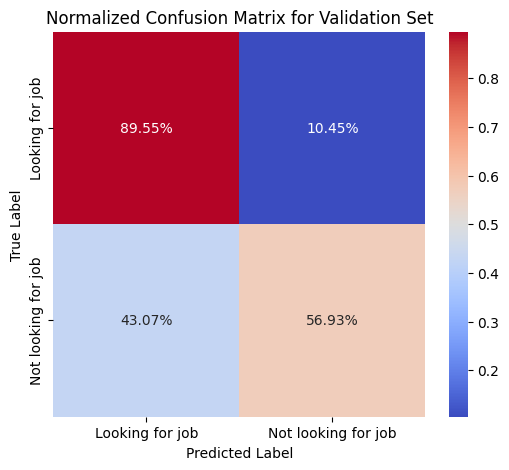

In [ ]:
#plotting the confusion matrix on the test set
val_cm = confusion_matrix(val_preds, y_test, normalize = "true")

val_cm = confusion_matrix(val_preds, y_test, normalize = "true")
print_ConfusionMatrix(val_cm, "Normalized Confusion Matrix for Validation Set", normalized =True)

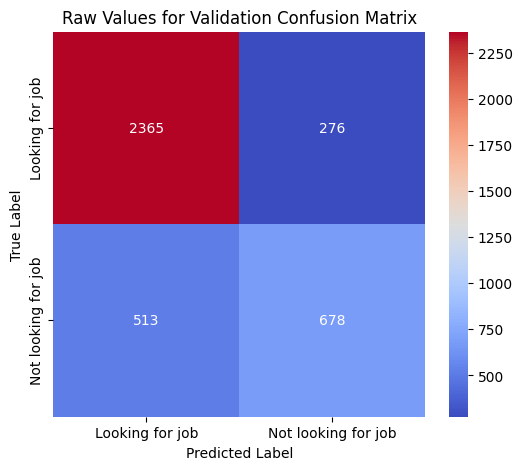

In [142]:
val_cm = confusion_matrix(val_preds, y_test)
print_ConfusionMatrix(val_cm, "Raw Values for Validation Confusion Matrix", normalized = False)

In [143]:
#Looking at the feature importances in our data set
feature_importances = rf_model.feature_importances_

Feature_Importances = pd.DataFrame({
    'Feature': train_dummies.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
top20 = Feature_Importances.iloc[:20, ]

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90     11503
         1.0       0.68      0.83      0.75      3823

    accuracy                           0.86     15326
   macro avg       0.81      0.85      0.82     15326
weighted avg       0.87      0.86      0.86     15326



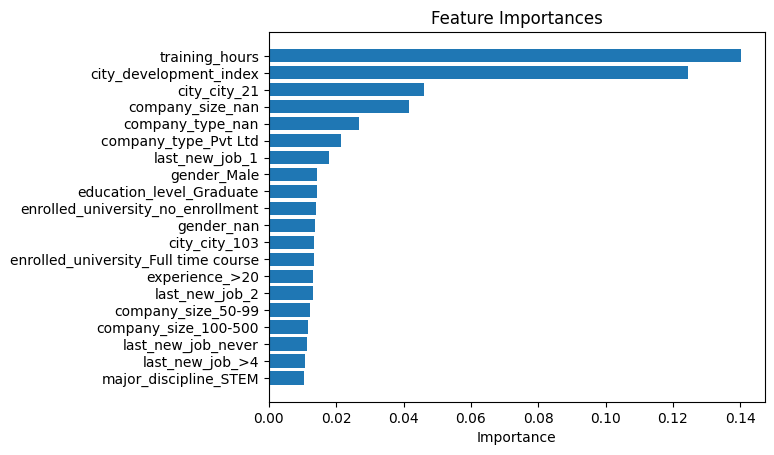

<Figure size 1920x1440 with 0 Axes>

In [60]:
#plotting the top 20 features important in our data set
plt.barh(top20["Feature"], top20["Importance"])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.figure(dpi = 300)
plt.show()

In [145]:
#Runnung a neural network on the model
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

hr_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")])

hr_nn2 = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")])

In [149]:
#Compiling the training set
hr_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
hr_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [150]:
#Training the model
history = hr_nn.fit(x=x_train, y=y_train, batch_size=32, callbacks=[early_stop], epochs=50)
history2 = hr_nn2.fit(x=x_train, y=y_train, batch_size=32, callbacks=[early_stop], epochs=50)

Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9505 - loss: 0.1115
Epoch 2/50
118/479 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - loss: 0.1097

c:\Users\uramac\miniconda3\envs\behavioral-data-science\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9482 - loss: 0.1144
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9505 - loss: 0.1131
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9494 - loss: 0.1189
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9451 - loss: 0.1212
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9485 - loss: 0.1170
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9501 - loss: 0.1137
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9501 - loss: 0.1118
Epoch 9/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9467 - loss: 0.1163
Epoch 10/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9470 - loss: 0.1127
Epoch 11/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9513 - loss: 0.1162
Epoch 12/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9471 - loss: 0.1123
Epoch 13/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accurac

ValueError: You must call `compile()` before using the model.

In [ ]:
#Evaluating the model on the test set
hr_nn.evaluate(x_test, y_test)
hr_nn2.evaluate(x_test,y_test)

nn_val_preds = hr_nn.predict(x_test)
y_pred = (nn_val_preds > 0.7).astype(y_train.dtype)
nn_val_preds2 = hr_nn2.predict(x_test)
y_pred2 = (nn_val_preds2 > 0.7).astype(y_train.dtype)

Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7349 - loss: 0.6012
Epoch 2/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7800 - loss: 0.4741
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7827 - loss: 0.4698
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7855 - loss: 0.4581
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7944 - loss: 0.4415
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7958 - loss: 0.4364
Epoch 7/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8028 - loss: 0.4279
Epoch 8/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8035 - loss: 0.4257
Epoch 9/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8076 - loss: 0.4191
Epoch 10/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8075 - loss: 0.4195
Epoch 11/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8056 - loss: 0.4157
Epoch 12/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#Plotting a confusion matrix on the neural net results
nn_val_cm = confusion_matrix(y_test, y_pred, normalize= "true")
print_ConfusionMatrix(nn_val_cm, "Normalized Confusion Matrix for Validation Set", normalized= True)

In [ ]:
nn_val_cm2 = confusion_matrix(y_test, y_pred2, normalize= "true")
print_ConfusionMatrix(nn_val_cm2, "Normalized Confusion Matrix for Validation Set", normalized= True)

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_test,
    nn_val_preds,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_test,
    nn_val_preds2,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)